# Quantify junction diversity
## Within junction distance
Create distance matrix between isolates based on pangraph of one junction. Consider the following distances:
- jaccard index of shared sequence length
- jaccard index of shared blogs (problem: don't take into account long deletions that could just have been one event)
- jaccard index of shared edges (problem: sequences might have shared blogs but completely different edges)
- number of divergence points in paths, solve by getting longest common subsequence (Needleman-Wunsch) (doesn't consider movement of blogs)


In [5]:
# set working directory to project folder
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import altair as alt
import numpy as np
import pypangraph as pp
from Bio import Phylo, SeqIO, pairwise2
from Bio import Align

from junction_analyis.diversity_metrics import compare_sequences_by_shared_proportion, calculate_block_ji_matrix, calculate_edge_ji_matrix, calculate_divergence_matrix
from junction_analyis.plotting import plot_heatmap_hover

In [8]:
_fname = f"../config/junction_stats.csv"
jdf = pd.read_csv(_fname)
jdf

edge  n_iso  n_blocks  has_dupl  n_categories  \
0    HUTOPWFGVH_f__WJBYSSJHSE_f    222         5     False             3   
1    IZQZNHJQRQ_f__ZVPGGEJIIF_f    222         3     False             2   
2    JNLRGIQXOF_f__YQUHGDANHE_f    222         3     False             2   
3    JMOMDSHCBS_r__SPDPCYMYDN_r    222         3     False             2   
4    JKRDVEYDGL_f__OTPJRRWJRK_f    222         3     False             2   
..                          ...    ...       ...       ...           ...   
543  GPXHVRRZLC_f__KYQOKYBCOW_f      2        12     False             2   
544  EOBHADSLFU_f__SKPHAXSFLS_r      2         1     False             1   
545  XXIWNZXZTK_f__ZLAJFQLBFQ_r      2         3     False             2   
546  YUOECYBHUS_f__ZTHKZYHPIX_f      2        20      True             2   
547  KIVDDRSTJR_f__QQSILILDBT_r      2         1     False             1   

     majority_category  singleton  cat_entropy  n_nodes  min_length  \
0                  218      False     0.100354       11       18177   
1                  221       True     0.028831        5       11740   
2                  221       True     0.028831        5       28035   
3                  220      False     0.051397        5        7366   
4                  221       True     0.028831        5       10058   
..                 ...        ...          ...      ...         ...   
543                  1       True     0.693147       18       65788   
544                  2      False     0.000000        1        7231   
545                  1       True     0.693147        6       83630   
546                  1       True     0.693147       35       66710   
547                  2      False     0.000000        1       11508   

     max_length    mean_length  n_all_cores  core_left_length  \
0         18954   18190.108108          218           16280.0   
1         12517   11743.500000          221            1530.0   
2         29472   28041.472973          221           23758.0   
3          8143    7373.000000          220            2781.0   
4         48233   10229.959459          221            7295.0   
..          ...            ...          ...               ...   
543      105315   85551.500000            0           18606.0   
544        7231    7231.000000            2            7231.0   
545       83630   83630.000000            2           31644.0   
546      186048  126379.000000            0           60232.0   
547       11508   11508.000000            2           11508.0   

     core_right_length  transitive  nonempty_acc_len  nonempty_freq  \
0               1699.0       False             727.5       0.018018   
1              10210.0       False             777.0       0.004505   
2               4277.0       False            1437.0       0.004505   
3               4585.0       False             777.0       0.009009   
4               2763.0       False           38175.0       0.004505   
..                 ...         ...               ...            ...   
543            29024.0       False           34255.5       1.000000   
544             7231.0        True               NaN       0.000000   
545            48921.0       False               NaN       0.000000   
546             5710.0       False           60437.0       1.000000   
547            11508.0        True               NaN       0.000000   

     pangenome_len  
0           1684.0  
1            768.0  
2           1433.0  
3            768.0  
4          37225.0  
..             ...  
543       100857.0  
544         3298.0  
545        73408.0  
546       160404.0  
547         1447.0  

[548 rows x 19 columns]

In [9]:
#example_junction = jdf.iloc[0].edge
#example_junction = "ATPWUNKKID_f__KKPYPKGMXA_f"
example_junction = "CIRMBUYJFK_f__CWCCKOQCWZ_r"
example_pangraph = pp.Pangraph.from_json(f"../results/junction_pangraphs/{example_junction}.json")
example_pangraph.to_blockstats_df()

count  n_strains  duplicated   core    len
block_id                                                        
185719230501067033        4          4       False  False   4204
517157241956952768        7          7       False  False   1248
693804415432571803      170        170       False  False   4736
913783977968963568      168        168       False  False    133
964531385716605116       13         13       False  False   1239
1314867519434933921     169        169       False  False   1920
1708810210093552769     221        221       False  False   2589
2278011600046483881       1          1       False  False  37622
3035246746052306249     169        169       False  False   7212
5100696243500885373     169        169       False  False    884
5611279500882571565     170        170       False  False    526
6097212296783908714     219        219       False  False    302
6304055291150384278     220        220       False  False    519
6423057522397590848     170        170       False  False    116
6932368721519041699      22         18        True  False    768
7754538651979209778     166        166       False  False    294
7844090243072536214       1          1       False  False   1446
7987278316461198430     170        170       False  False   1759
9242629882957449119     168        168       False  False    812
9834685609301298901     170        170       False  False    829
10145330714100251892    221        221       False  False    184
11400043001338627984    222        222       False   True   3488
11426489427845291638    168        168       False  False    470
11445151531734952644    170        170       False  False    322
11455254306155687211    219        219       False  False   4795
11588582069103229002    166        166       False  False   1013
12055620567302113403    221        221       False  False   2807
12883103544713419939    166        166       False  False    322
13357752436170011985    170        170       False  False   1858
13879318911159590194    219        219       False  False   1541
14506298656834147691    169        169       False  False   8823
15395175763379073292    169        169       False  False   4141
15558722379768673797    170        170       False  False    230
16056383497489254679    170        170       False  False    142
16491840897895487317    170        170       False  False   5508
16494405553751752639    222        222       False   True   2990
16543294998939926181    169        169       False  False    562
16556873922195442803      2          2       False  False   1661
16982887268023976258     12         12       False  False    624
17115477248436968411    220        220       False  False   2547
18228278273347143766      1          1       False  False    820

### Shared sequence length

In [10]:
sequence_comparison_df = example_pangraph.pairwise_accessory_genome_comparison()
jaccard_sequences_df, diff, shared = compare_sequences_by_shared_proportion(sequence_comparison_df, order = "hierarchical")
plot_heatmap_hover(jaccard_sequences_df, diff, shared, show_tick_labels=False, similarity_measure="shared_proportion")

### Shared blocks

In [11]:
jaccard_blocks_df, diff, shared = calculate_block_ji_matrix(example_pangraph, order="hierarchical")
plot_heatmap_hover(jaccard_blocks_df, diff, shared, show_tick_labels=False, similarity_measure="shared_blocks")

### Shared edges

In [12]:
jaccard_edges_df, diff, shared = calculate_edge_ji_matrix(example_pangraph, order="hierarchical")
plot_heatmap_hover(jaccard_edges_df, diff, shared, show_tick_labels=False, similarity_measure="shared_edges")

### Number of divergence points betwenn paths

In [13]:
divergence_points_mat = calculate_divergence_matrix(example_pangraph, order="hierarchical")
plot_heatmap_hover(divergence_points_mat, show_tick_labels=False, similarity_measure="divergence_points")

/Users/mariebecker/Documents/Uni/ETH/Masterarbeit/marie-junctions/junction_analyis/helpers.py:5: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



## Metric comparison
Scatter plots comparing the difference metrices with each other

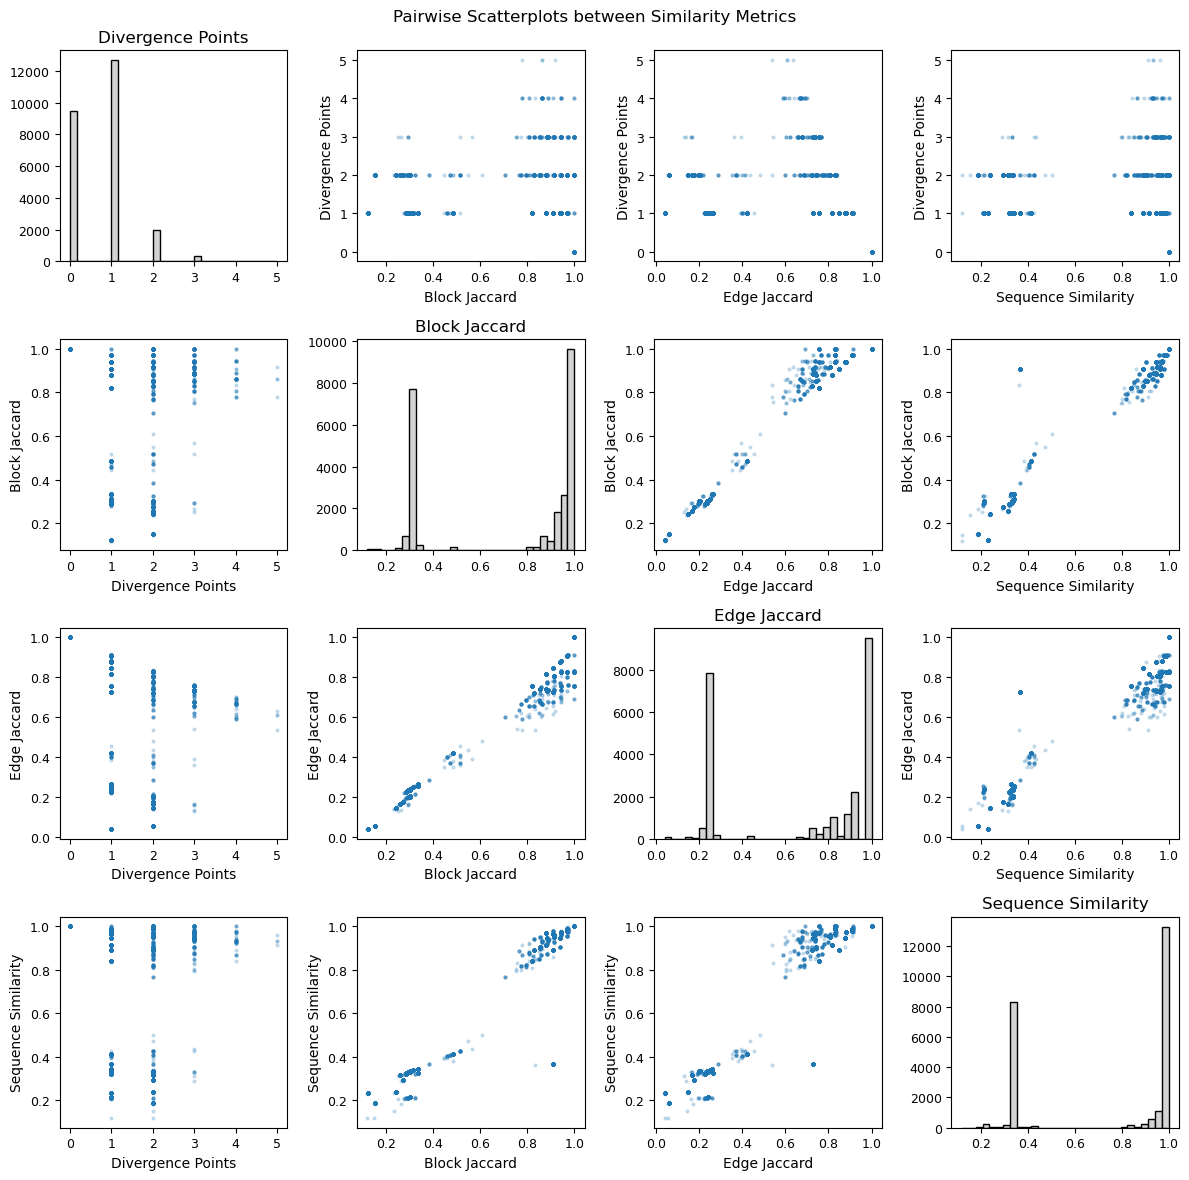

In [14]:
def plot_similarity_scatter(matrices, labels=None, figsize=(10, 10)):
    """
    Plot pairwise scatterplots between multiple similarity matrices.
    
    Parameters
    ----------
    matrices : list of pd.DataFrame
        List of symmetric similarity matrices (same index and columns).
    labels : list of str, optional
        Labels for each matrix. If None, generic labels are used.
    figsize : tuple
        Figure size.
    """
    n = len(matrices)
    if labels is None:
        labels = [f"Metric {i+1}" for i in range(n)]

    ref_order = matrices[0].index
    matrices = [m.loc[ref_order, ref_order] for m in matrices]

    def flatten_upper(df):
        vals = df.values
        iu = np.triu_indices_from(vals, k=1)
        return vals[iu]

    flat_vals = [flatten_upper(m) for m in matrices]

    fig, axes = plt.subplots(n, n, figsize=figsize)

    for i in range(n):
        for j in range(n):
            ax = axes[i, j]

            if i == j:
                # Diagonal: show histogram and label
                ax.hist(flat_vals[i], bins=30, color='lightgray', edgecolor='black')
                ax.set_title(labels[i], fontsize=12)
            else:
                ax.scatter(flat_vals[j], flat_vals[i], s=4, alpha=0.2)
                ax.set_xlabel(labels[j], fontsize=10)
                ax.set_ylabel(labels[i], fontsize=10)

            # Make ticks smaller but visible
            ax.tick_params(axis='both', which='major', labelsize=9)

    fig.suptitle("Pairwise Scatterplots between Similarity Metrics", fontsize=12)
    fig.tight_layout()
    plt.show()

plot_similarity_scatter([divergence_points_mat, jaccard_blocks_df, jaccard_edges_df, jaccard_sequences_df], labels=["Divergence Points", "Block Jaccard", "Edge Jaccard", "Sequence Similarity"], figsize=(12,12))

## Pipeline for one junction

/Users/mariebecker/Documents/Uni/ETH/Masterarbeit/marie-junctions/junction_analyis/helpers.py:5: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



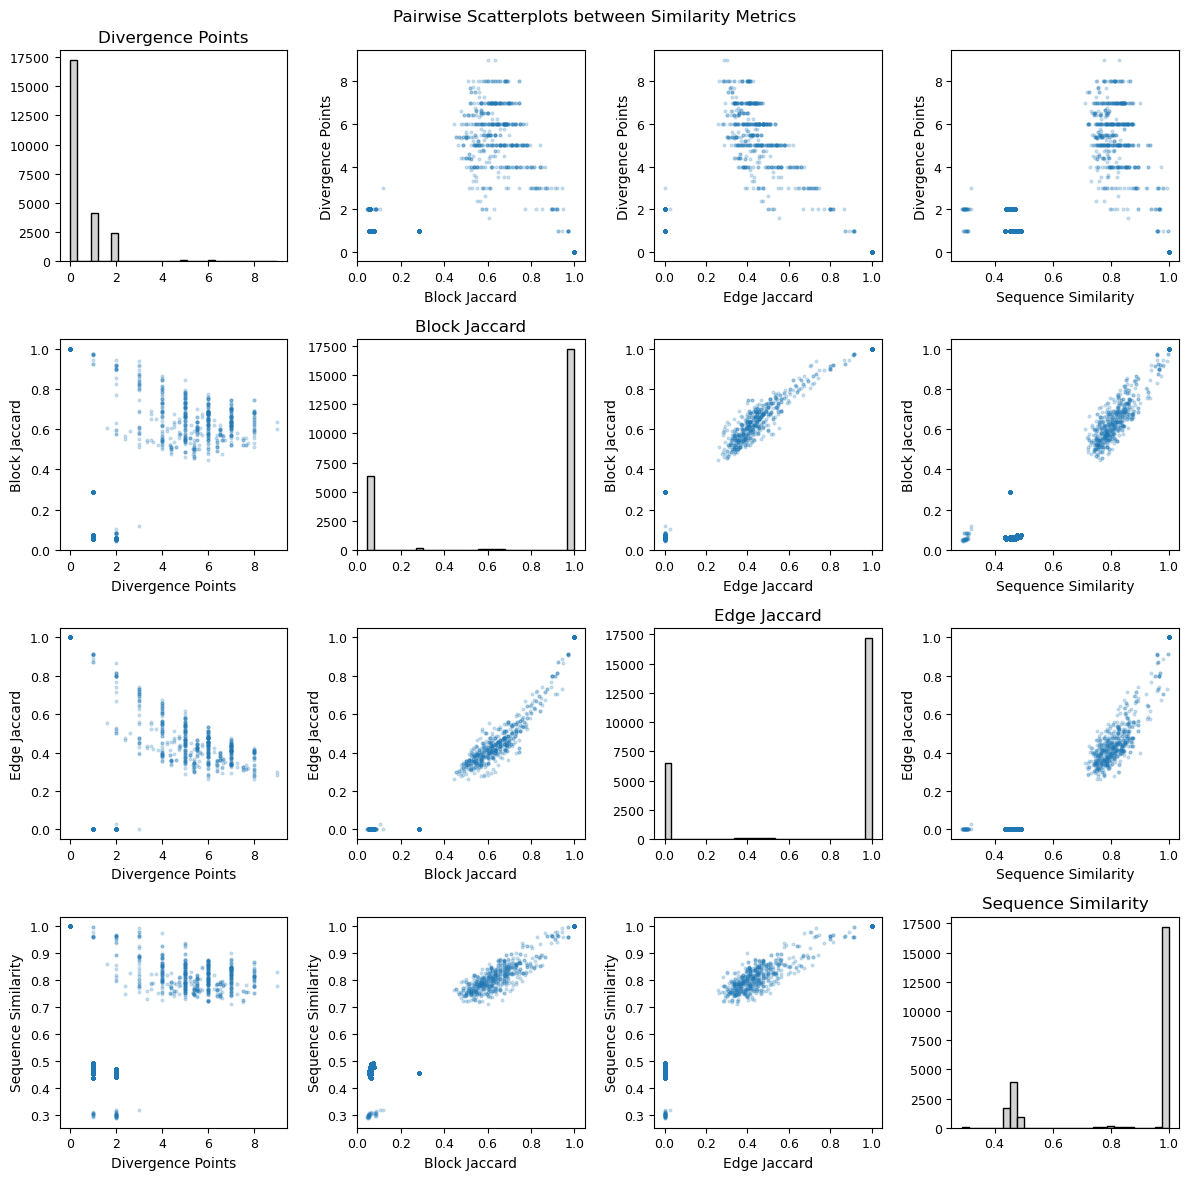

In [15]:
example_junction = "ATPWUNKKID_f__KKPYPKGMXA_f"
example_pangraph = pp.Pangraph.from_json(f"../results/junction_pangraphs/{example_junction}.json")
example_pangraph.to_blockstats_df()

sequence_comparison_df = example_pangraph.pairwise_accessory_genome_comparison()
jaccard_sequences_df, diff, shared = compare_sequences_by_shared_proportion(sequence_comparison_df, order = "hierarchical")
plot_heatmap_hover(jaccard_sequences_df, diff, shared, show_tick_labels=False, similarity_measure="shared_proportion")

jaccard_blocks_df, diff, shared = calculate_block_ji_matrix(example_pangraph, order="hierarchical")
plot_heatmap_hover(jaccard_blocks_df, diff, shared, show_tick_labels=False, similarity_measure="shared_blocks")

jaccard_edges_df, diff, shared = calculate_edge_ji_matrix(example_pangraph, order="hierarchical")
plot_heatmap_hover(jaccard_edges_df, diff, shared, show_tick_labels=False, similarity_measure="shared_edges")

divergence_points_mat = calculate_divergence_matrix(example_pangraph, order="hierarchical")
plot_heatmap_hover(divergence_points_mat, show_tick_labels=False, similarity_measure="divergence_points")

plot_similarity_scatter([divergence_points_mat, jaccard_blocks_df, jaccard_edges_df, jaccard_sequences_df], labels=["Divergence Points", "Block Jaccard", "Edge Jaccard", "Sequence Similarity"], figsize=(12,12))

## Pypangraph playground

In [16]:
example_pangraph.to_blockcount_df()
example_pangraph.paths.keys()

['NZ_CP023844.1',
 'NZ_CP124511.1',
 'NZ_OW849064.1',
 'NZ_CP014497.1',
 'NZ_CP124372.1',
 'NZ_CP107114.1',
 'NZ_OX637964.1',
 'NZ_CP124355.1',
 'NZ_CP019008.1',
 'NZ_CP133923.1',
 'NZ_CP013658.1',
 'NZ_CP124467.1',
 'NZ_CP107155.1',
 'NZ_CP018991.1',
 'NZ_CP098219.1',
 'NZ_OW968277.1',
 'NZ_CP032265.1',
 'NZ_CP080120.1',
 'NZ_CP124392.1',
 'NZ_CP124481.1',
 'NZ_CP124424.1',
 'NZ_CP021454.1',
 'NZ_LR890693.1',
 'NZ_CP124320.1',
 'NZ_CP124429.1',
 'NZ_CP124495.1',
 'NZ_CP069488.1',
 'NZ_CP107120.1',
 'NZ_CP013831.1',
 'NZ_AP018784.1',
 'NZ_CP097360.1',
 'NZ_CP107128.1',
 'NZ_CP021935.1',
 'NZ_CP035516.1',
 'NZ_CP023853.1',
 'NZ_CP124341.1',
 'NZ_CP018983.1',
 'NZ_CP082831.1',
 'NZ_CP029420.1',
 'NZ_AP022525.1',
 'NZ_CP104846.1',
 'NZ_CP124405.1',
 'NZ_CP095520.1',
 'NZ_CP035720.1',
 'NZ_CP124353.1',
 'NZ_CP102061.1',
 'NZ_CP015074.2',
 'NZ_CP104848.1',
 'NZ_CP059281.1',
 'NZ_CP103755.1',
 'NZ_CP124455.1',
 'NZ_CP097367.1',
 'NZ_CP107147.1',
 'NZ_AP022326.1',
 'NZ_CP107134.1',
 'NZ_LS999

In [17]:

aligner = Align.PairwiseAligner()


aligner.mode = 'global'
aligner.match_score = 1
aligner.mismatch_score = 0
alignments = aligner.align("GAACT", "GAT")
alignment = alignments[0]
alignments[0].sequences

for index in range(len(alignments)):
    print(alignments[index])
    print(alignments[index].score)

# block duplication, we want block with less divergence points

target            0 GAACT 5
                  0 ||--| 5
query             0 GA--T 3

3.0
target            0 GAACT 5
                  0 |-|-| 5
query             0 G-A-T 3

3.0


In [18]:
aln1, aln2 = alignments[0]
aln2

'GA--T'

GAACT
||--|
GA--T

Beispiel für Sequenzen, die je nach scoring system 2 oder eine divergence sequenz haben

GAACT
|-|-|
G-A-T